In [1]:
import sys

sys.path.append('../src')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import torch

import os
from glob import glob

import pickle
import yaml
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from utils.result_visualization import *
from utils.scalers import *
from dataset.sea_fog_dataset import Temporal_Graph_Signal

In [3]:
hour = 1

In [4]:
if hour == 1:
    input_length = 120
    output_length = 6
    
elif hour == 3:
    input_length = 120
    output_length = 18
    
elif hour == 6:
    input_length = 102
    output_length = 36

In [5]:
dirs = glob(f'../exp/1212/IC_PN_BEATS/forecast_{hour}hour*/*')
dirs.sort()
dirs

['../exp/1212/IC_PN_BEATS/forecast_1hour_regression_all_combine_loss/1212_183331',
 '../exp/1212/IC_PN_BEATS/forecast_1hour_regression_all_single_loss/1212_201233',
 '../exp/1212/IC_PN_BEATS/forecast_1hour_regression_vis_combine_loss/1212_215357',
 '../exp/1212/IC_PN_BEATS/forecast_1hour_regression_vis_single_loss/1212_233246']

In [6]:
target_col_num = [10, 21, 32, 43, 54]
loss_list = ['Loss_1,2', 'Loss_2', 'Loss_1,3', 'Loss_3']
port_list = ['증산도', '불무기도', '장도', '목포', '여수항']

In [7]:
scaler = pickle.load(open('../src/data/SeaFog/graph_signal/scaler.pickle', 'rb'))
mean, std = scaler.x_shift, scaler.x_scale

mean = np.array(mean)
std = np.array(std)

mean = mean[target_col_num]
std = std[target_col_num]

In [8]:
loader = Temporal_Graph_Signal('std')
loader.path = '../src/data/SeaFog/graph_signal'
loader.preprocess_dataset()

train_dataset, _, test_dataset = loader.get_dataset(
            num_timesteps_in=input_length,
            num_timesteps_out=output_length,
            batch_size=1)

train_anomaly = []
for batch in train_dataset[0]:
    train_anomaly.append(batch.anomaly)
train_anomaly = torch.stack(train_anomaly, axis=0)

train_fog = sum(train_anomaly)

print(train_fog)
print(train_fog / train_anomaly.shape[0] * 100)

In [10]:
target_anomaly = []
input_timeseries = []
target_timeseries = []

for batch in test_dataset:
    target_anomaly.append(batch.anomaly)
    input_timeseries.append(batch.x[target_col_num])
    target_timeseries.append(batch.y[target_col_num])
    
target_anomaly = torch.stack(target_anomaly, axis=0)
input_timeseries = torch.stack(input_timeseries, axis=0)
target_timeseries = torch.stack(target_timeseries, axis=0)

# Get average score of all port

In [11]:
total_result = {loss: {} for loss in loss_list}

for exp_dir in dirs:
    if exp_dir.split('/')[-2].split('_')[-3] == 'all':
        if exp_dir.split('/')[-2].split('_')[-2] == 'combine':
            name = 'Loss_1,2'
        else:
            name = "Loss_2"
    else:
        if exp_dir.split('/')[-2].split('_')[-2] == 'combine':
            name = 'Loss_1,3'
        else:
            name = "Loss_3"
            
    config, _, test_result = get_exp_result_files(exp_dir)
    
    if exp_dir.split('/')[-2].split('_')[-2] == 'combine':
        pred_anomaly = torch.sigmoid(torch.Tensor(test_result['anomaly_pred'])) > 0.5
        
    else:
        node_by_node_pred = []
        forecast = test_result['forecast'].squeeze()
        for node in range(5):
            port_forecast = forecast[:,node,:]

            inv_port_forecast = inv_std_scaler(port_forecast.reshape(-1), mean[node], std[node])
            inv_port_forecast = inv_port_forecast.reshape(forecast.shape[0], -1)

            inv_port_forecast = inv_port_forecast[:, -1]

            pred_anomaly = inv_port_forecast < 1000

            node_by_node_pred.append(torch.Tensor(pred_anomaly))

        pred_anomaly = torch.stack(node_by_node_pred, axis=0).T
        
    
    result = {'Acc': 0, 'Precision': 0, 'Recall': 0, 'F1': 0}

    _acc = accuracy_score(target_anomaly.reshape(-1), pred_anomaly.reshape(-1)) * 100
    _precision = precision_score(target_anomaly.reshape(-1), pred_anomaly.reshape(-1)) * 100
    _recall = recall_score(target_anomaly.reshape(-1), pred_anomaly.reshape(-1)) * 100
    _f1 = f1_score(target_anomaly.reshape(-1), pred_anomaly.reshape(-1)) * 100


    result['Acc'] = round(_acc, 2)
    result['Precision'] = round(_precision, 2)
    result['Recall'] = round(_recall, 2)
    result['F1'] = round(_f1, 2)
    
    total_result[name] = result

In [12]:
total_df = pd.DataFrame(total_result)
total_df.T

,Acc,Precision,Recall,F1
"Loss_1,2",98.23,43.09,86.18,57.45
Loss_2,99.11,75.88,52.44,62.02
"Loss_1,3",98.66,51.19,78.86,62.08
Loss_3,99.13,74.21,57.32,64.68


In [13]:
port_total_result = {loss: {} for loss in loss_list}

for exp_dir in dirs:
    if exp_dir.split('/')[-2].split('_')[-3] == 'all':
        if exp_dir.split('/')[-2].split('_')[-2] == 'combine':
            name = 'Loss_1,2'
        else:
            name = "Loss_2"
    else:
        if exp_dir.split('/')[-2].split('_')[-2] == 'combine':
            name = 'Loss_1,3'
        else:
            name = "Loss_3"
            
    config, _, test_result = get_exp_result_files(exp_dir)
    
    if exp_dir.split('/')[-2].split('_')[-2] == 'combine':
        pred_anomaly = torch.sigmoid(torch.Tensor(test_result['anomaly_pred'])) > 0.5
        
    else:
        node_by_node_pred = []
        forecast = test_result['forecast'].squeeze()
        
        for node in range(5):
            port_forecast = forecast[:,node,:]

            inv_port_forecast = inv_std_scaler(port_forecast.reshape(-1), mean[node], std[node])
            inv_port_forecast = inv_port_forecast.reshape(forecast.shape[0], -1)

            inv_port_forecast = inv_port_forecast[:, -1]

            pred_anomaly = inv_port_forecast < 1000

            node_by_node_pred.append(torch.Tensor(pred_anomaly))

        pred_anomaly = torch.stack(node_by_node_pred, axis=0).T
    
    
    port_result = {port: {} for port in port_list}    
    
    for idx, port in enumerate(port_list):
        _result = {'Acc': 0, 'Precision': 0, 'Recall': 0, 'F1': 0}

        _acc = accuracy_score(target_anomaly[:, idx], pred_anomaly[:, idx]) * 100
        _precision = precision_score(target_anomaly[:, idx], pred_anomaly[:, idx]) * 100
        _recall = recall_score(target_anomaly[:, idx], pred_anomaly[:, idx]) * 100
        _f1 = f1_score(target_anomaly[:, idx], pred_anomaly[:, idx]) * 100


        _result['Acc'] = round(_acc, 2)
        _result['Precision'] = round(_precision, 2)
        _result['Recall'] = round(_recall, 2)
        _result['F1'] = round(_f1, 2)

        port_result[port] = _result
        
    port_total_result[name] = port_result

In [14]:
loss_df = []
for loss in loss_list:
    loss_df.append(pd.DataFrame(port_total_result[loss]).T)

In [15]:
loss_df[1]

,Acc,Precision,Recall,F1
증산도,99.04,63.64,35.00,45.16
불무기도,98.76,83.87,60.47,70.27
장도,98.22,78.08,54.81,64.41
목포,99.60,50.00,35.71,41.67
여수항,99.92,33.33,50.00,40.00


# Visualization of Visible Feature

In [16]:
exp_dir = dirs[0]

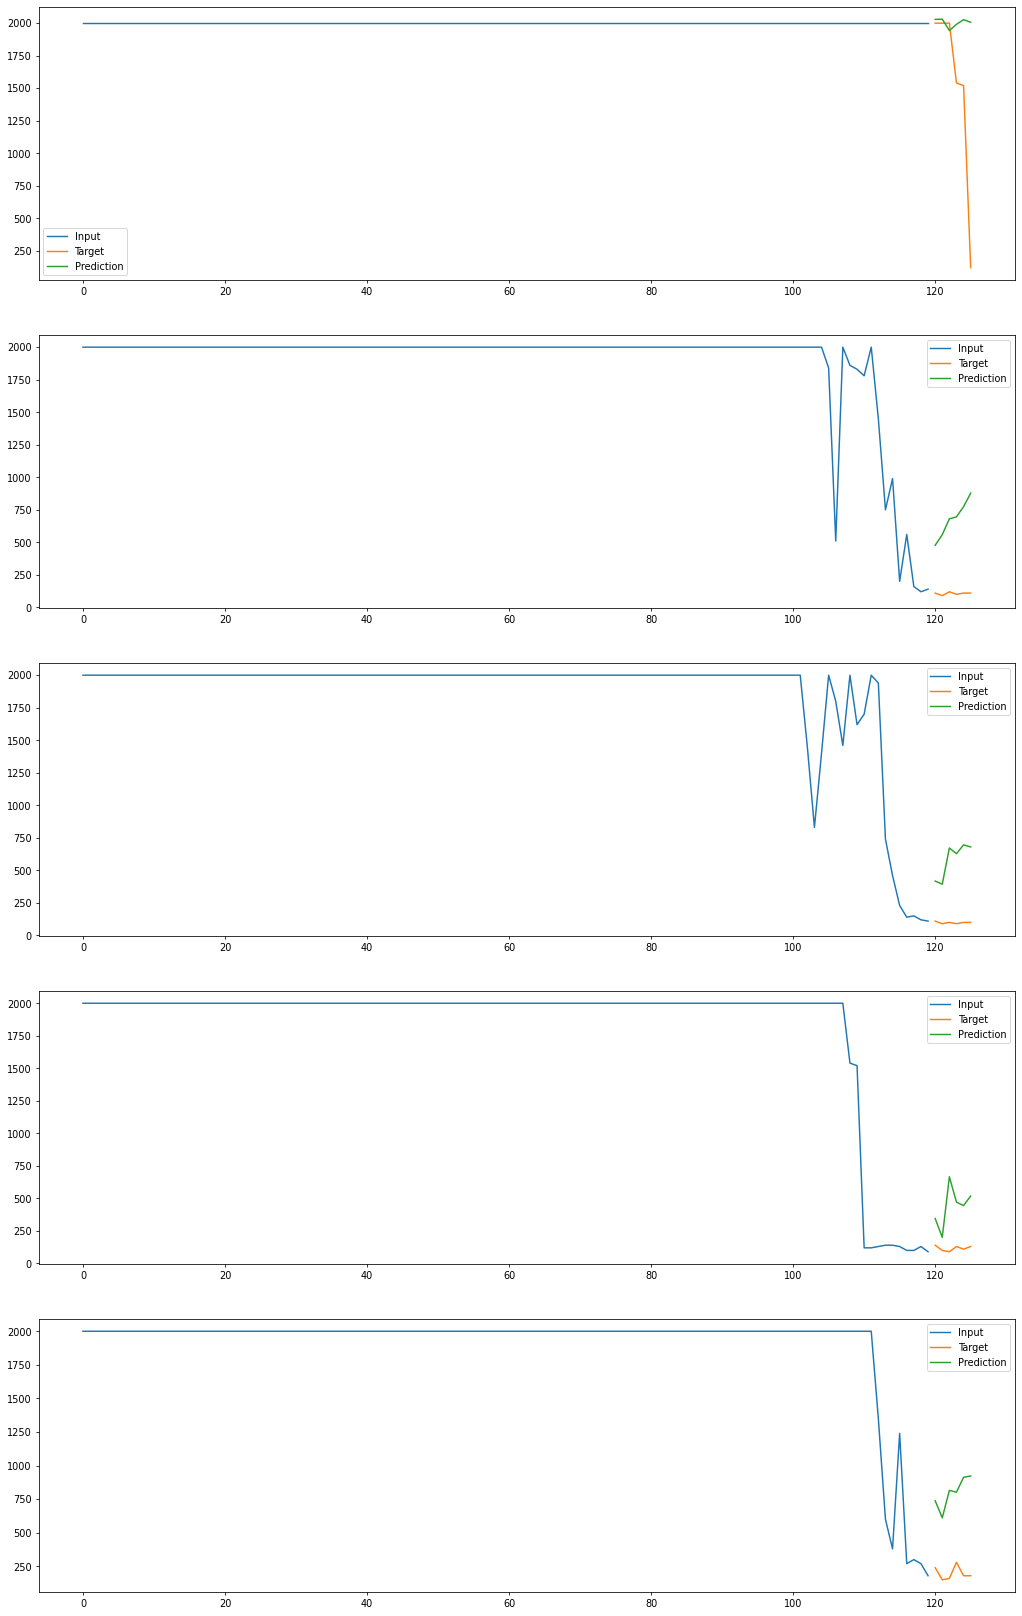

In [37]:
config, _, test_result = get_exp_result_files(exp_dir)


forecast = test_result['forecast'].squeeze()

fog_batch, fog_node_list = np.where(target_anomaly)

nrow = 5
ncol = 1

x_axis = np.arange(input_length+output_length)

f, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(18*ncol, 6*nrow), dpi=70)


for ii in range(nrow):
    inputs = input_timeseries[fog_batch[ii], fog_node_list[ii]]
    targets = target_timeseries[fog_batch[ii], fog_node_list[ii]]
    predictions = forecast[fog_batch[ii], fog_node_list[ii]]
    
    
    inputs = inv_std_scaler(inputs, mean[fog_node_list[ii]], std[fog_node_list[ii]])
    targets = inv_std_scaler(targets, mean[fog_node_list[ii]], std[fog_node_list[ii]])
    predictions = inv_std_scaler(predictions, mean[fog_node_list[ii]], std[fog_node_list[ii]])
    
    axes[ii].plot(x_axis[:input_length], inputs, label='Input')
    axes[ii].plot(x_axis[input_length:], targets, label='Target')
    axes[ii].plot(x_axis[input_length:], predictions, label='Prediction')
    axes[ii].legend()

# Inferenced Latent Graph Structure

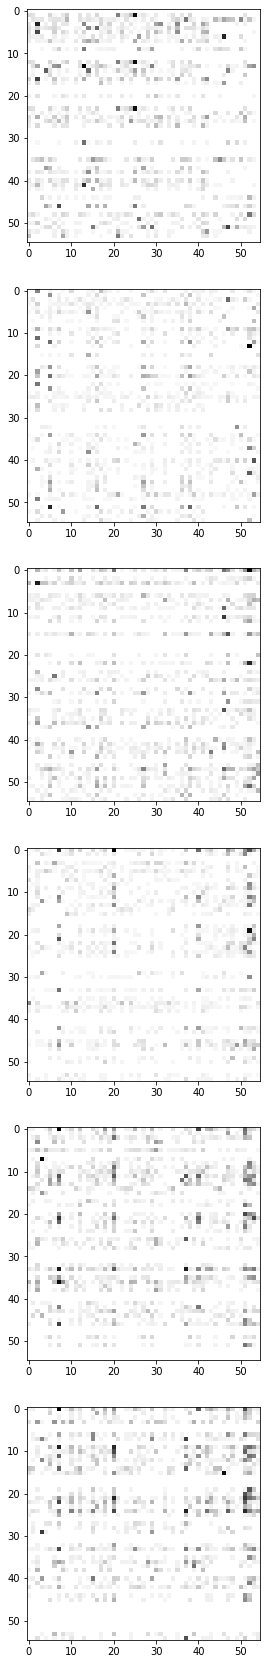

In [35]:
nrows = config.forecasting_module.stack_num+config.forecasting_module.singular_stack_num

fig, axes = plt.subplots(nrows=nrows, ncols=1,
                        figsize=(10*1,5*nrows))

adj_matrix_1 = test_result['attention_matrix'][fog_batch[0]]['Double']
adj_matrix_2 = test_result['attention_matrix'][fog_batch[0]]['Singular']


for ii in range(config.forecasting_module.stack_num):
    axes[ii].imshow(adj_matrix_1[ii].squeeze(), cmap='Greys')
    
for i in range(config.forecasting_module.singular_stack_num):
    axes[ii+i+1].imshow(adj_matrix_2[i].squeeze(), cmap='Greys')